# Figure 2. Parity plots of GS- and GFA-relevant properties

Make sure environment is using `glasspy 0.4.6`.

In [1]:
from glasspy.predict.models import GlassNet
from glasspy.data import SciGlass

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
myrcparams = {
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'axes.labelcolor': 'black',
    'xtick.labelcolor': 'black',
    'ytick.labelcolor': 'black',
    'legend.fontsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.autolayout': True,
    'figure.figsize': (4.5,4)
}
plt.rcParams.update(myrcparams)

In [3]:
glassnet_no_stnn = GlassNet(st_models=[])
glassnet_stnn = GlassNet()

In [4]:
cols = ['Tg', 'Tc', 'Tx', 'Tliq', 'T_Umax', 'log_Umax']
titles = ['$T_g$', '$T_c$', '$T_x$', '$T_l$', '$T_{max(U)}$', '$log(U_{max})$']

# Data

## Get variations in property values for duplicate compositions

In [5]:
source = SciGlass()
df = source.data
source.remove_duplicate_composition(aggregator='std')
df_std = source.data.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax',
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})
quantiles = df_std.property[cols].quantile(q=0.75)

## Load GlassNet training and test data

In [6]:
glassnet_test_df = glassnet_stnn.get_test_dataset()
glassnet_train_df = glassnet_stnn.get_training_dataset()

In [7]:
X_glassnet_test = glassnet_test_df.elements
X_glassnet_train = glassnet_train_df.elements
X_glassnet_total = pd.concat( (X_glassnet_train, X_glassnet_test) )

In [8]:
X_glassnet_feats_test, feats = glassnet_stnn.featurizer(X_glassnet_test, return_cols = True)
X_glassnet_feats_train, feats = glassnet_stnn.featurizer(X_glassnet_train, return_cols = True)

In [9]:
X_glassnet_feats_test = pd.DataFrame(X_glassnet_feats_test, columns = feats)
X_glassnet_feats_train = pd.DataFrame(X_glassnet_feats_train, columns = feats)

In [10]:
X_glassnet_feats_test.index = X_glassnet_test.index
X_glassnet_feats_train.index = X_glassnet_train.index
X_glassnet_feats_total = pd.concat( (X_glassnet_feats_train, X_glassnet_feats_test) )

In [11]:
y_glassnet_test = glassnet_test_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})
y_glassnet_train = glassnet_train_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})
y_glassnet_total = pd.concat( (y_glassnet_train, y_glassnet_test) )

# Predictions on GlassNet test set

## GlassNet

In [12]:
y_pred_glassnet_no_stnn = glassnet_no_stnn.predict(X_glassnet_test)
y_pred_glassnet_stnn = glassnet_stnn.predict(X_glassnet_test)
y_pred_glassnet_no_stnn = y_pred_glassnet_no_stnn.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})
y_pred_glassnet_stnn = y_pred_glassnet_stnn.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})
y_pred_glassnet_no_stnn.index = y_glassnet_test.index
y_pred_glassnet_stnn.index = y_glassnet_test.index

In [13]:
y_glassnet_test_cpy = y_glassnet_test.copy()
y_glassnet_test_cpy.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'}, inplace=True)
y_glassnet_test_cpy.columns = [col+'_true' for col in y_glassnet_test_cpy.columns]

In [14]:
y_pred_glassnet_stnn_cpy = y_pred_glassnet_stnn.copy()
y_pred_glassnet_stnn_cpy.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'}, inplace=True)
y_pred_glassnet_stnn_cpy.columns = [col+'_stnn' for col in y_pred_glassnet_stnn_cpy.columns]

In [15]:
y_pred_glassnet_no_stnn_cpy = y_pred_glassnet_no_stnn.copy()
y_pred_glassnet_no_stnn_cpy.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'}, inplace=True)
y_pred_glassnet_no_stnn_cpy.columns = [col+'_no_stnn' for col in y_pred_glassnet_no_stnn_cpy.columns]

In [16]:
final_glassnet_pred_df = pd.concat( (y_glassnet_test_cpy, y_pred_glassnet_stnn_cpy, 
                                     y_pred_glassnet_no_stnn_cpy), 
                                     axis=1 )

In [17]:
final_glassnet_pred_df.to_csv( 'glassnet_test_preds_0_4_6_stnn.csv')

## Random forest

In [18]:
n_iter = 10

In [19]:
y_pred_glassnet_rf_dfs = []
y_pred_glassnet_rf = pd.DataFrame( np.zeros( y_pred_glassnet_stnn.shape ), index = y_pred_glassnet_stnn.index, columns = y_pred_glassnet_stnn.columns )

r2_df = pd.DataFrame( np.zeros( (n_iter, len(cols)) ) )
mae_df = pd.DataFrame( np.zeros( (n_iter, len(cols)) ) )
r2_df.columns = [f'R2_{col}' for col in cols]
mae_df.columns = [f'MAE_{col}' for col in cols]

rf = RandomForestRegressor()
for i in range(n_iter):

    this_y_pred_df = pd.DataFrame( np.zeros( y_pred_glassnet_stnn.shape ), index = y_pred_glassnet_stnn.index, columns = y_pred_glassnet_stnn.columns )
    for t, col in enumerate( cols ):
        
        this_y_train = y_glassnet_train[col].dropna()
        this_X_train = X_glassnet_feats_train.loc[ this_y_train.index, : ]
        this_y_test = y_glassnet_test[col].dropna()
        this_X_test = X_glassnet_feats_test.loc[ this_y_test.index, : ]

        rf.fit(this_X_train, this_y_train)

        this_y_pred_all = rf.predict(X_glassnet_feats_test)
        this_y_pred = rf.predict(this_X_test)
        
        this_y_pred_df[col] = this_y_pred_all

        y_pred_glassnet_rf.loc[this_y_test.index, col] = this_y_pred
        
        r2_df.loc[i,f'R2_{col}'] = r2_score( this_y_test, this_y_pred )
        mae_df.loc[i,f'MAE_{col}'] = mean_absolute_error( this_y_test, this_y_pred )
    y_pred_glassnet_rf_dfs.append( this_y_pred_df[cols] )

In [30]:
for i in range(n_iter):
    y_pred_glassnet_rf_dfs[i].to_csv(f'rf_preds_iteration{i}.csv')

In [31]:
print( r2_df.mean(axis=0) )
print( r2_df.std(axis=0) )

R2_Tg          0.967011
R2_Tc          0.960201
R2_Tx          0.957613
R2_Tliq        0.975119
R2_T_Umax      0.764142
R2_log_Umax    0.775744
dtype: float64
R2_Tg          0.000220
R2_Tc          0.000266
R2_Tx          0.000848
R2_Tliq        0.000320
R2_T_Umax      0.009901
R2_log_Umax    0.012227
dtype: float64


In [32]:
print( mae_df.mean(axis=0) )
print( mae_df.std(axis=0) )

MAE_Tg          18.932111
MAE_Tc          34.390771
MAE_Tx          28.903085
MAE_Tliq        32.191368
MAE_T_Umax      44.405131
MAE_log_Umax     0.362674
dtype: float64
MAE_Tg          0.051123
MAE_Tc          0.094231
MAE_Tx          0.124483
MAE_Tliq        0.112406
MAE_T_Umax      0.950188
MAE_log_Umax    0.004796
dtype: float64


In [33]:
y_pred_glassnet_rf_cpy = y_pred_glassnet_rf.copy()
y_pred_glassnet_rf_cpy.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquiadus':'Tliq'}, inplace=True)
y_pred_glassnet_rf_cpy.columns = [col+'_rf' for col in y_pred_glassnet_rf_cpy.columns]

In [34]:
y_pred_glassnet_no_rf_cpy = y_pred_glassnet_no_stnn.copy()
y_pred_glassnet_no_rf_cpy.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'}, inplace=True)
y_pred_glassnet_no_rf_cpy.columns = [col+'_no_rf' for col in y_pred_glassnet_no_rf_cpy.columns]

In [35]:
final_glassnet_pred_df = pd.concat( (y_glassnet_test_cpy, y_pred_glassnet_rf_cpy, 
                                     y_pred_glassnet_no_rf_cpy), 
                                     axis=1 )

In [36]:
final_glassnet_pred_df.to_csv( 'glassnet_test_preds_rf.csv')

## Parity plots

In [37]:
glassnet_test_pred_rf = pd.read_csv('glassnet_test_preds_rf.csv', index_col=0)
glassnet_test_pred_stnn = pd.read_csv('glassnet_test_preds_0_4_6_stnn.csv', index_col=0)

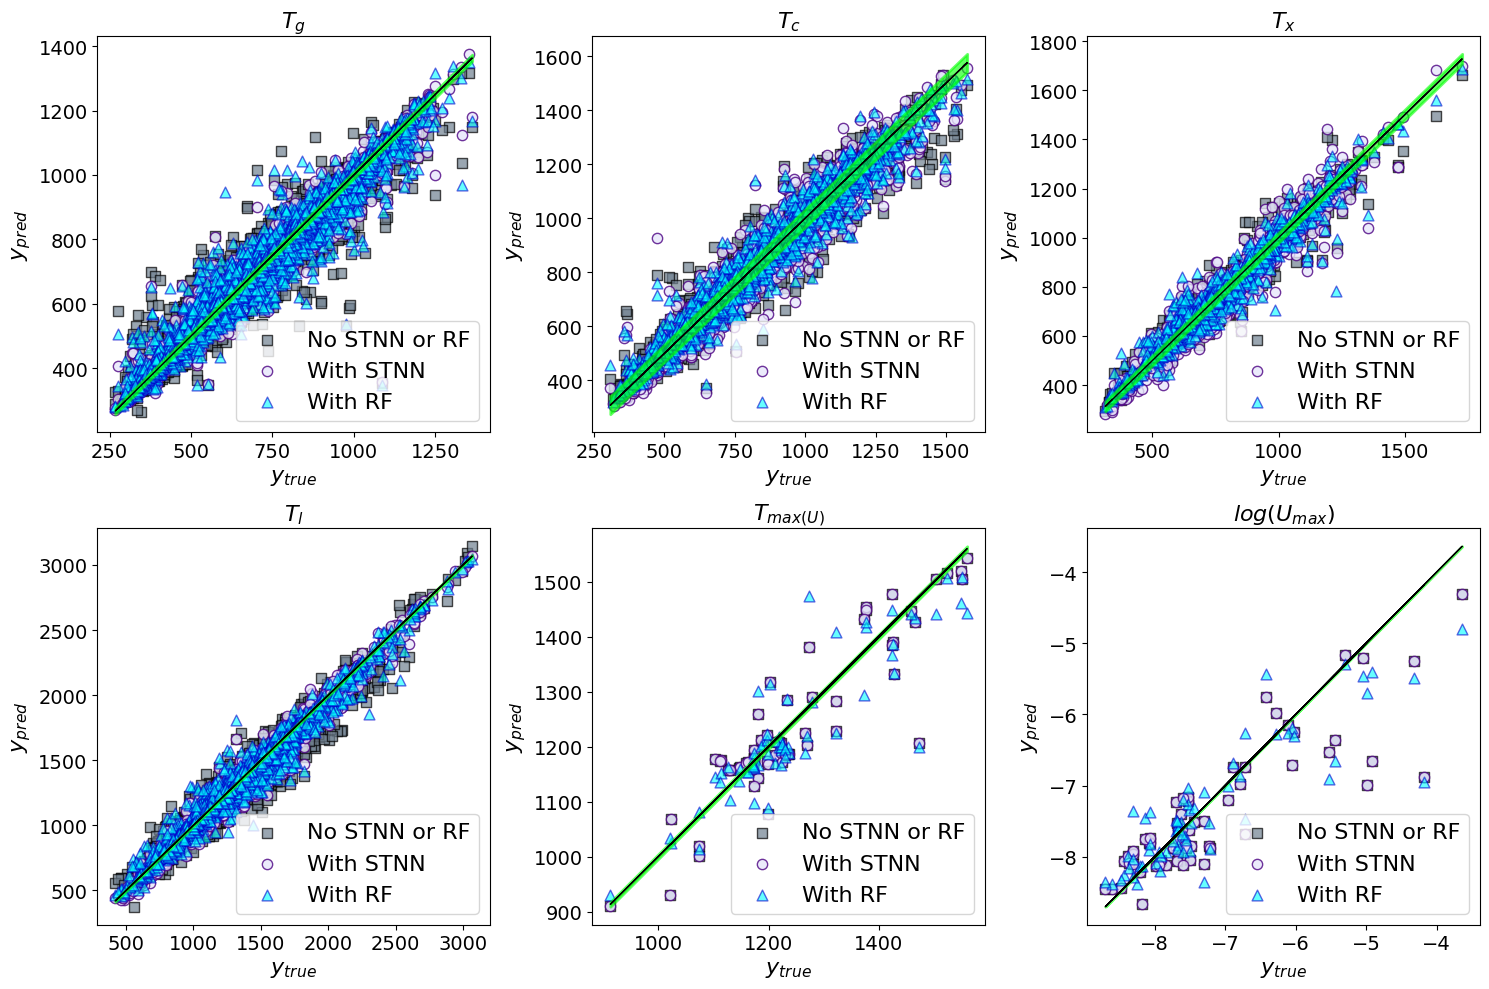

In [38]:
r2_arr = np.zeros( (4,6) )
letters = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']
x_shifts = [40, 40, 40, 40, 40, 0.25]
y_shifts = [50, 80, 80, 0, 80, 0.6]
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(15,10))
for i,col in enumerate(cols):
    y_true = glassnet_test_pred_rf[f'{col}_true']
    y_rf = glassnet_test_pred_rf[f'{col}_rf']
    y_no_rf = glassnet_test_pred_rf[f'{col}_no_rf']
    y_stnn = glassnet_test_pred_stnn[f'{col}_stnn']
    y_no_stnn = glassnet_test_pred_stnn[f'{col}_no_stnn']
    
    y_true_nona = y_true.dropna()
    y_no_rf_nona = y_no_rf[ y_true_nona.index ]
    y_rf_nona = y_rf[ y_true_nona.index ]
    y_stnn_nona = y_stnn[ y_true_nona.index ]

    y_agg = ( y_rf_nona + y_stnn_nona ) / 2
    r2_arr[:,i] = [ r2_score(y_true_nona, y_no_rf_nona), r2_score(y_true_nona, y_stnn_nona), r2_score(y_true_nona, y_rf_nona), r2_score(y_true_nona, y_agg) ]
  
    if i < 3:
        ax = axes[0,i]
    else:
        ax = axes[1,i-3]
    ax.plot(y_true_nona, y_true_nona, color='black',linewidth=1.0)
    ax.scatter(y_true_nona, y_no_rf_nona, marker='s', s=50, alpha=0.7, color='slategrey', edgecolor='black', label='No STNN or RF')
    ax.scatter(y_true_nona, y_stnn_nona, marker='o', s=55, alpha=0.8, color='lavender', edgecolor='indigo', label='With STNN')
    ax.scatter(y_true_nona, y_rf_nona, marker='^', s=60, alpha=0.6, color='cyan', edgecolor='mediumblue', label='With RF')
    y_true_line = np.linspace(min(y_true_nona), max(y_true_nona), 100)
    ax.fill_between(y_true_line, (y_true_line-quantiles[col]), (y_true_line+quantiles[col]), color='lime', alpha=.6, linewidth=2.0)
    ax.set_xlabel(r'$y_{true}$')
    ax.set_ylabel(r'$y_{pred}$')
    ax.set_title(titles[i])
    x = ax.get_xlim()[0] + x_shifts[i]
    y = ax.get_ylim()[1] - y_shifts[i]
    #ax.text(x, y, letters[i], fontsize=24 )
    ax.legend(loc='lower right')
    
fig.savefig(f'figure2.png', dpi=600)

In [39]:
quantiles

Tg          1.029259e+01
Tc          3.323402e+01
Tx          2.050610e+01
Tliq        7.723145e+00
T_Umax      4.242641e+00
log_Umax    9.135822e-10
Name: 0.75, dtype: float64